# Paths

In [1]:
datasets_path     = 'datasets/annotated/INF692_GEST_CLAS_GE.v3i.folder/'
models_path       = 'models/'
tensorboard_path  = 'Tensorboard/YOLO-TL/'

dataset = 'INF692_GEST_CLAS_GE/' # train, test, val
# dataset = 'INF692_GEST_CLAS_MY/' # train, test, val

In [2]:
train_dir = f'{datasets_path}/train'
valid_dir = f'{datasets_path}/valid'
test_dir  = f'{datasets_path}/test'

# Libs

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms

from torchvision import datasets
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt

from datetime import datetime

from tqdm import tqdm

import copy

from ultralytics import YOLO

# Dataloader

In [4]:
def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()

In [5]:
my_transform = transforms.Compose([
    transforms.Resize((640, 480)),  # ajuste conforme o necessário
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
train_data = datasets.ImageFolder(root=train_dir, transform=my_transform)
valid_data = datasets.ImageFolder(root=valid_dir, transform=my_transform)
test_data  = datasets.ImageFolder(root=test_dir,  transform=my_transform)

# DataLoaders
batch_size = 64  # Verificar memória disponível

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

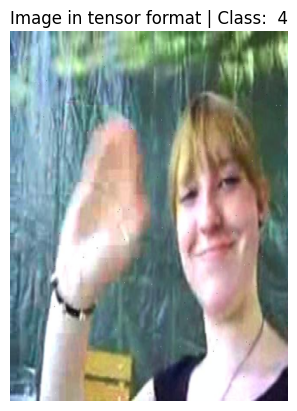

In [7]:
images, labels = next(iter(train_loader))
my_tensor_image_show(images[0], label=labels[0])

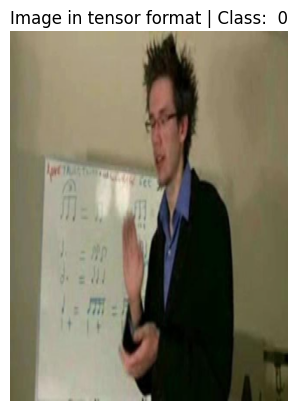

In [8]:
images, labels = next(iter(valid_loader))
my_tensor_image_show(images[0], label=labels[0])

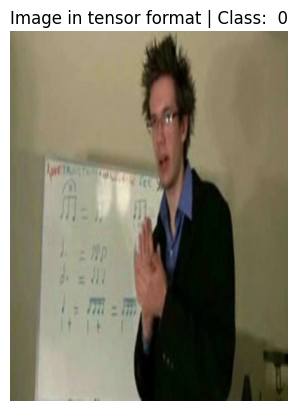

In [9]:
images, labels = next(iter(test_loader))
my_tensor_image_show(images[0], label=labels[0])

# Validation

In [10]:
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

# Training

In [11]:
def plot_layers ( net , writer, epoch ) :
    layers = list(net.classifier.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Linear) :

#             writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
#                                 epoch )
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
#             writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
#                                     epoch )
            layer_id += 1



def train ( train_loader, valid_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
        
    accuracies = []
    max_accuracy = -1.0  

    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            predict_y = net( train_x )
            
            # Loss:
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # Back propagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # Accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        accuracy = validate(net, valid_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        path = f'{models_path}MyYolo-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model   

# Run

In [12]:
model = YOLO('yolov8n.pt')  # Load a pre-trained YOLOv8 model

In [13]:
# Check which layers are frozen
for name, param in model.named_parameters():
    print(f"{name}")

model.model.0.conv.weight
model.model.0.bn.weight
model.model.0.bn.bias
model.model.1.conv.weight
model.model.1.bn.weight
model.model.1.bn.bias
model.model.2.cv1.conv.weight
model.model.2.cv1.bn.weight
model.model.2.cv1.bn.bias
model.model.2.cv2.conv.weight
model.model.2.cv2.bn.weight
model.model.2.cv2.bn.bias
model.model.2.m.0.cv1.conv.weight
model.model.2.m.0.cv1.bn.weight
model.model.2.m.0.cv1.bn.bias
model.model.2.m.0.cv2.conv.weight
model.model.2.m.0.cv2.bn.weight
model.model.2.m.0.cv2.bn.bias
model.model.3.conv.weight
model.model.3.bn.weight
model.model.3.bn.bias
model.model.4.cv1.conv.weight
model.model.4.cv1.bn.weight
model.model.4.cv1.bn.bias
model.model.4.cv2.conv.weight
model.model.4.cv2.bn.weight
model.model.4.cv2.bn.bias
model.model.4.m.0.cv1.conv.weight
model.model.4.m.0.cv1.bn.weight
model.model.4.m.0.cv1.bn.bias
model.model.4.m.0.cv2.conv.weight
model.model.4.m.0.cv2.bn.weight
model.model.4.m.0.cv2.bn.bias
model.model.4.m.1.cv1.conv.weight
model.model.4.m.1.cv1.bn.weigh

In [14]:
# for param in model.parameters():
#     param.requires_grad = False

# model.classifier[6] = torch.nn.Linear(4096,17)  #
# model.classifier[6].requires_grad_(True)
# model.classifier[4].requires_grad_(True)
# model.classifier[1].requires_grad_(True)
# model.features[10].requires_grad_(True)

In [15]:
# Check which layers are frozen
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

model.model.0.conv.weight: Frozen
model.model.0.bn.weight: Frozen
model.model.0.bn.bias: Frozen
model.model.1.conv.weight: Frozen
model.model.1.bn.weight: Frozen
model.model.1.bn.bias: Frozen
model.model.2.cv1.conv.weight: Frozen
model.model.2.cv1.bn.weight: Frozen
model.model.2.cv1.bn.bias: Frozen
model.model.2.cv2.conv.weight: Frozen
model.model.2.cv2.bn.weight: Frozen
model.model.2.cv2.bn.bias: Frozen
model.model.2.m.0.cv1.conv.weight: Frozen
model.model.2.m.0.cv1.bn.weight: Frozen
model.model.2.m.0.cv1.bn.bias: Frozen
model.model.2.m.0.cv2.conv.weight: Frozen
model.model.2.m.0.cv2.bn.weight: Frozen
model.model.2.m.0.cv2.bn.bias: Frozen
model.model.3.conv.weight: Frozen
model.model.3.bn.weight: Frozen
model.model.3.bn.bias: Frozen
model.model.4.cv1.conv.weight: Frozen
model.model.4.cv1.bn.weight: Frozen
model.model.4.cv1.bn.bias: Frozen
model.model.4.cv2.conv.weight: Frozen
model.model.4.cv2.bn.weight: Frozen
model.model.4.cv2.bn.bias: Frozen
model.model.4.m.0.cv1.conv.weight: Froze

In [16]:
def get_device():
    """
    Detecta e retorna o melhor dispositivo disponível (CUDA, MPS ou CPU).
    """
    if torch.cuda.is_available():
        return 'cuda'
    return 'cpu'

def print_device_info(device: str):
    """
    Exibe informações sobre o dispositivo utilizado.
    """
    print(f"Dispositivo selecionado: {device}")
    if device == 'cuda':
        print("CUDA disponível:", torch.cuda.is_available())
        print("Total de GPUs:", torch.cuda.device_count())
        print("GPU atual:", torch.cuda.current_device())
        print("Nome da GPU:", torch.cuda.get_device_name(
            torch.cuda.current_device()))
    else:
        print("Nenhuma GPU CUDA disponível.")

In [21]:
print("Versão do PyTorch:", torch.__version__)

my_device = get_device()
print_device_info(my_device)

model = model.to(my_device)

epochs = 100
lr = 1e-4
prefix = 'Yolo-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

# net = train(train_loader, valid_loader, model, len(train_data),
#             epochs=epochs, device=my_device, save=False, 
#             prefix=prefix, lr=lr, layers2tensorboard=False, batch_size=batch_size)

Versão do PyTorch: 2.7.1+cu128
Dispositivo selecionado: cpu
Nenhuma GPU CUDA disponível.


In [18]:
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    data = test_loader
    
    # my_transform = AlexNet_Weights.IMAGENET1K_V1.transforms()
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = [
        "Daffodil", "Snowdrop", "Lily Valley", "Bluebell", "Crocus",
        "Iris", "Tigerlily", "Tulip", "Fritillary", "Sunflower",
        "Daisy", "Coltsfoot", "Dandelion", "Cowslip", "Buttercup",
        "Windflower", "Pansy"
    ]

    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    
    # return dataset_classes[y], dataset_classes[data[i][1]], confidence


sample_and_predict(net)


NameError: name 'net' is not defined